<a href="https://colab.research.google.com/github/JuNYoUnGPaark/ML_2_Class/blob/main/Inception_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
import torch
from torch import nn

## Basic Conv-layer Module

In [ ]:
# Conv-BN-ReLU Module
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, bias=False, **kwargs),
                                        nn.BatchNorm2d(out_channels, eps=1e-3),
                                        nn.ReLU())

    def forward(self, x):
        x = self.conv_block(x)
        return x

## Main Inception Module
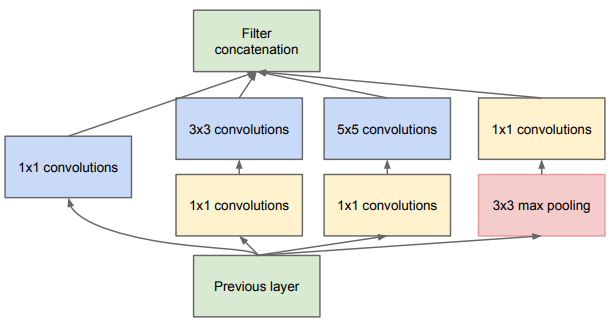

In [ ]:
# Main Inception Module
# 왼쪽부터 차례대로
# red = reduce

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super().__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(BasicConv2d(in_channels, ch3x3red, kernel_size=1),
                                     BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1))

        self.branch3 = nn.Sequential(BasicConv2d(in_channels, ch5x5red, kernel_size=1),
                                     BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2))

        self.branch4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                     BasicConv2d(in_channels, pool_proj, kernel_size=1))

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

## Auxiliary Classifier Module

- An average pooling layer with 5×5 filter size and stride 3, resulting in an 4×4×512 output
- A 1×1 convolution with 128 filters for dimension reduction and rectified linear activation.
- A fully connected layer with 1024 units and rectified linear activation.
- A dropout layer with 70% ratio of dropped outputs.
- A linear layer with softmax loss as the classifier (predicting the same 1000 classes as the
main classifier, but removed at inference time).


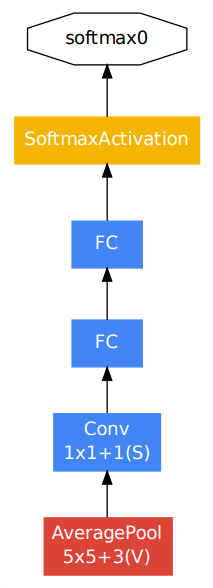

In [ ]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes, drop_p=0.7):
        super().__init__()

        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_p)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Full InceptionV1

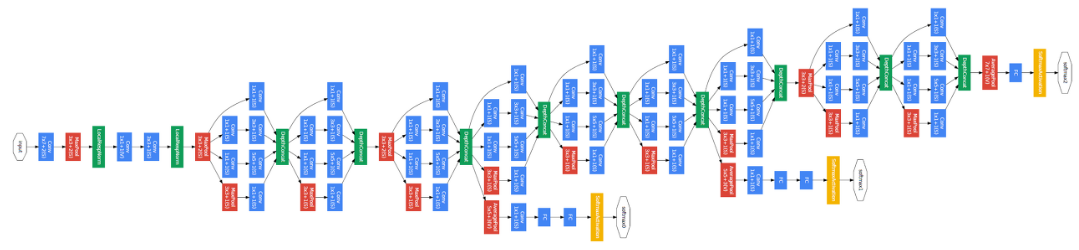

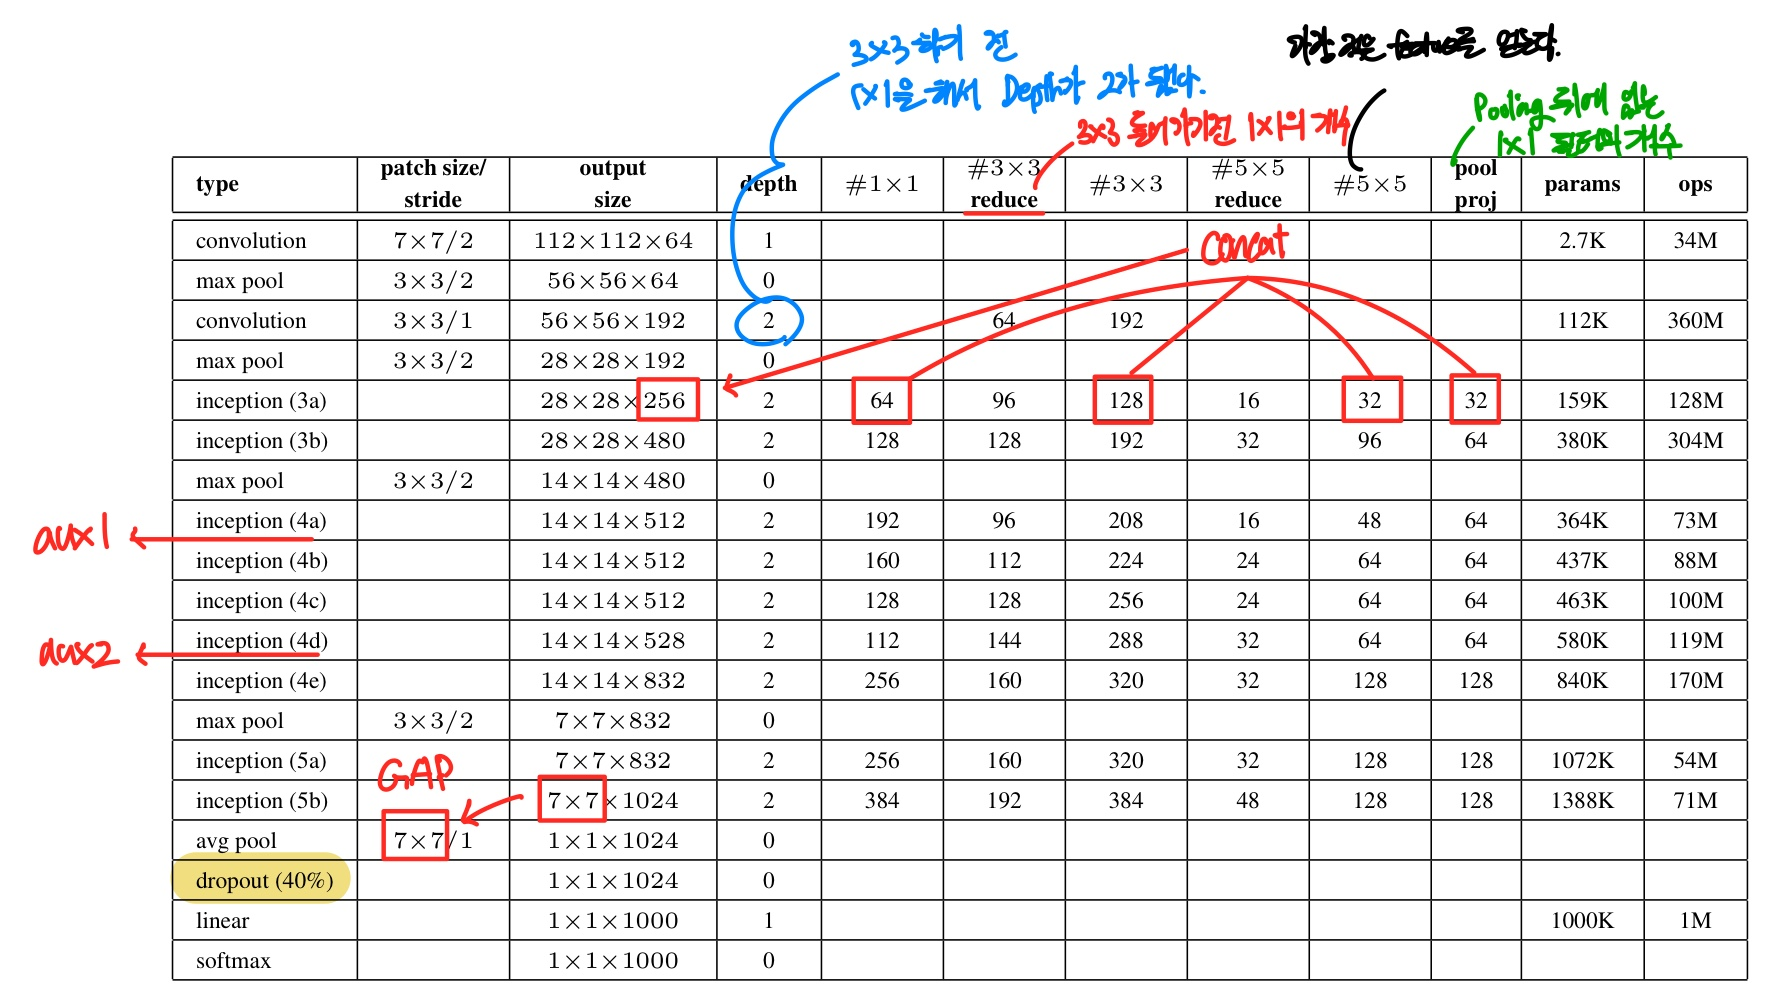

In [ ]:
class Inception_V1(nn.Module):
    def __init__(self, num_classes=1000, use_aux=True, init_weights=None, drop_p=0.4, drop_p_aux=0.7):
        super().__init__()

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2a = BasicConv2d(64, 64, kernel_size=1)
        self.conv2b = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)
        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)
        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        if use_aux:
            self.aux1 = InceptionAux(512, num_classes, drop_p=drop_p_aux)
            self.aux2 = InceptionAux(528, num_classes, drop_p=drop_p_aux)
        else:
            self.aux1 = None
            self.aux2 = None
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # GAP
        self.dropout = nn.Dropout(p=drop_p)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    torch.nn.init_trunc_normal_(m.weight, mean=0.0, std=0.01, a=-2, b=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2a(x)
        x = self.conv2b(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        if self.aux1 is not None and self.training:
            aux1 = self.aux1(x)
        else:
            aux1 = None  # 뭐라도 넣어놔야 not defined error 안 뜸

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.aux2 is not None and self.training:
            aux2 = self.aux2(x)
        else:
            aux2 = None
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x, aux2, aux1

In [ ]:
model = Inception_V1()

## Model Summary

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
summary(model, input_size=(2, 3, 224, 224), device='cpu')

Layer (type:depth-idx)                        Output Shape              Param #
Inception_V1                                  [2, 1000]                 6,379,984
├─BasicConv2d: 1-1                            [2, 64, 112, 112]         --
│    └─Sequential: 2-1                        [2, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                       [2, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                  [2, 64, 112, 112]         128
│    │    └─ReLU: 3-3                         [2, 64, 112, 112]         --
├─MaxPool2d: 1-2                              [2, 64, 56, 56]           --
├─BasicConv2d: 1-3                            [2, 64, 56, 56]           --
│    └─Sequential: 2-2                        [2, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                       [2, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-5                  [2, 64, 56, 56]           128
│    │    └─ReLU: 3-6                         [2, 64, 56, 56]           --
├─Bas